# Tutorial IV: Using Runner Advanced II

The purpose of this tutorial is to learn more about Runner's advanced features and advanced visualization options. The usecase and the data are the same.

Using code from the previous tutorial:

In [1]:
%%capture --no-stdout
    
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from hdbscan import HDBSCAN
from numba.errors import NumbaWarning
from numpy.random import RandomState
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from dpemu import runner
from dpemu.dataset_utils import load_digits_
from dpemu.filters.common import Missing
from dpemu.ml_utils import reduce_dimensions
from dpemu.nodes import Array
from dpemu.plotting_utils import visualize_best_model_params, visualize_scores, print_results_by_model

warnings.simplefilter("ignore", category=NumbaWarning)

def get_data():
    return load_digits_()


def get_err_root_node():
    err_root_node = Array()
    err_root_node.addfilter(Missing("probability", "missing_value"))
    return err_root_node


def get_err_params_list():
    p_steps = np.linspace(0, .5, num=6)
    err_params_list = [{"probability": p, "missing_value": 0} for p in p_steps]
    return err_params_list


class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(42)

    def run(self, _, data, params):
        reduced_data = reduce_dimensions(data, self.random_state)
        return None, reduced_data, {"reduced_data": reduced_data}


class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, data, params):
        pass

    def run(self, _, data, params):
        labels = params["labels"]
        fitted_model = self.get_fitted_model(data, params)
        return {
            "AMI": round(adjusted_mutual_info_score(labels, fitted_model.labels_, average_method="arithmetic"), 3),
            "ARI": round(adjusted_rand_score(labels, fitted_model.labels_), 3),
        }


class KMeansModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return KMeans(n_clusters=n_classes, random_state=self.random_state).fit(data)


class HDBSCANModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        return HDBSCAN(
            min_samples=params["min_samples"],
            min_cluster_size=params["min_cluster_size"],
            core_dist_n_jobs=1
        ).fit(data)


def main():
    data, labels, label_names, dataset_name = get_data()

    df = runner.run(
        train_data=None,
        test_data=data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(),
        model_params_dict_list=get_model_params_dict_list(labels),
    )

    print_results_by_model(df, ["missing_value_id", "labels", "reduced_data"])
    visualize(df, label_names, dataset_name, data)

Let's redo the step where we defined the hyperparameters used by our models. In the previous tutorial, we learned that Runner runs every model in the list defined by this function with all different sets of hyperparameters listed in the corresponding params_list -element. Now if we add more sets of hyperparameters to our only HDBSCAN's param_list, all these results will be listed under "HDBSCAN #1" in the resulting Dataframe. Using this information some of our visualizers are able to visualize hyperparameter-optimized results. Now we are also testing few different values for HDBSCAN's min_samples. Larger min_samples just means that more datapoints will be seen as noise.

In [2]:
def get_model_params_dict_list(labels):
    min_cluster_size_steps = [25, 50, 75]
    min_samples_steps = [1, 10]
    return [
        {"model": KMeansModel, "params_list": [{"labels": labels}]},
        {"model": HDBSCANModel, "params_list": [{
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "labels": labels
        } for min_cluster_size in min_cluster_size_steps for min_samples in min_samples_steps]},
    ]

Let's also partially redo our visualizations. First we would like to visualize the hyperparameter-optimized scores for each of the models. Secondly we would like to see the best hyperparameters for HDBSCAN given the error.

In [3]:
def visualize(df, label_names, dataset_name, data):
    visualize_scores(
        df,
        score_names=["AMI", "ARI"],
        is_higher_score_better=[True, True],
        err_param_name="probability",
        title=f"{dataset_name} clustering scores with missing pixels",
    )
    visualize_best_model_params(
        df,
        model_name="HDBSCAN",
        model_params=["min_cluster_size", "min_samples"],
        score_names=["AMI", "ARI"],
        is_higher_score_better=[True, True],
        err_param_name="probability",
        title=f"Best parameters for {dataset_name} clustering"
    )
    plt.show()

Let's check out the results. Scores for HDBSCAN seem slightly better and smaller min_samples seems to be a better fit for data with lots of error.

100%|██████████| 6/6 [00:19<00:00,  3.25s/it]


HDBSCAN #1


,AMI,ARI,missing_value,probability,min_cluster_size,min_samples,time_err,time_pre,time_mod
0,0.787,0.643,0,0.0,25.0,1.0,0.005,18.001,0.049
1,0.916,0.897,0,0.0,25.0,10.0,0.005,18.001,0.047
2,0.887,0.853,0,0.0,50.0,1.0,0.005,18.001,0.042
3,0.906,0.882,0,0.0,50.0,10.0,0.005,18.001,0.046
4,0.908,0.883,0,0.0,75.0,1.0,0.005,18.001,0.041
5,0.906,0.882,0,0.0,75.0,10.0,0.005,18.001,0.048
6,0.810,0.763,0,0.1,25.0,1.0,0.006,18.331,0.050
7,0.810,0.766,0,0.1,25.0,10.0,0.006,18.331,0.047
8,0.825,0.796,0,0.1,50.0,1.0,0.006,18.331,0.042
9,0.809,0.754,0,0.1,50.0,10.0,0.006,18.331,0.046


KMeans #1


,AMI,ARI,missing_value,probability,time_err,time_pre,time_mod
0,0.917,0.897,0,0.0,0.005,18.001,0.091
1,0.800,0.744,0,0.1,0.006,18.331,0.145
2,0.681,0.618,0,0.2,0.004,19.096,0.133
3,0.540,0.484,0,0.3,0.007,18.648,0.188
4,0.396,0.331,0,0.4,0.007,17.965,0.208
5,0.242,0.169,0,0.5,0.006,18.241,0.280


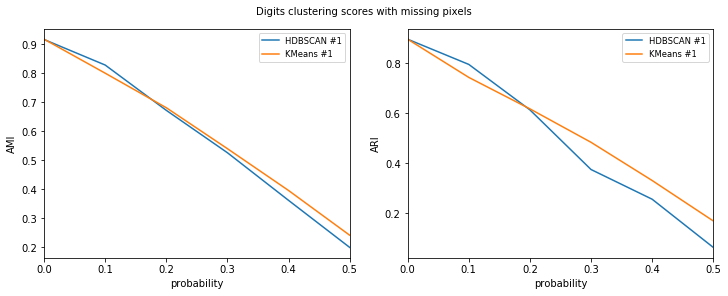

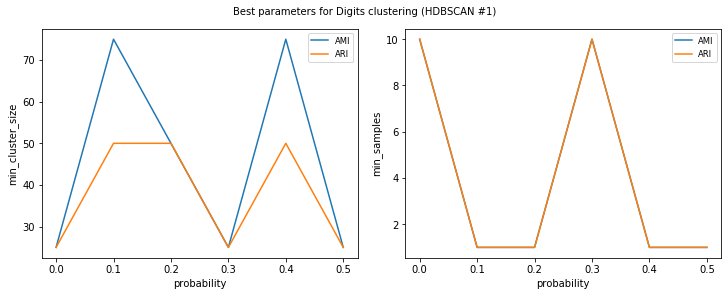

In [4]:
main()

The notebook for this tutorial can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/tutorials/Using_Runner_Advanced_II.ipynb).